https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169875#sec014


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import skimage
import sys

import torch
from torch.utils.data import DataLoader

from segmentation_functions import channel_deconvolution
from wavelet_color_decomposition import *

In [2]:
IMAGE_SHAPE = 512

# 1) Load data

In [3]:
# he NLST
he_nlst_folder = "../data/he/"
he_nlst = [_ for _ in os.listdir(he_nlst_folder) if _.endswith(".png")]

# he MDACC
he_mdacc_folder = "../data/HE_unlabeled/"
he_mdacc = [_ for _ in os.listdir(he_mdacc_folder) if _.endswith(".png")]

# ihc (ori)
ihc_ori = []
for folder in ["CD8", "CD3", "CD68", "PD-L1"]:
    ihc_ori.extend([os.path.join("../data", folder, "ori", _) for _ in os.listdir(os.path.join("../data", folder, "ori"))
                   if _.endswith(".png")])
np.random.seed(1243)
ihc_ori = np.random.choice(ihc_ori, len(he_nlst), replace=False)

# ihc (h channel)
ihc_h_folder = "../data/IHC_H_channel/"
ihc_h = [_ for _ in os.listdir(ihc_h_folder) if _.endswith(".png")]

# Create image dict
he_nlst.sort()
he_mdacc.sort()
ihc_ori.sort()
ihc_h.sort()

image_dict = dict()
slides_he = []
slides_ihc = []
for index in he_nlst:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_nlst_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(he_nlst_folder, index)
    if index[0] == "N":
        _dict['magnitude'] = 20
    else:
        _dict['magnitude'] = 40
    _dict['type'] = "he"
    image_dict[index] = _dict
    slides_he.append(index.split("_")[0])
'''
for index in he_mdacc:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_mdacc_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(he_mdacc_folder, index)
    _dict['magnitude'] = 20
    _dict['type'] = "he"
    image_dict[index] = _dict
    slides_he.append(index.split("_")[0])
'''
for index in ihc_ori:
    _dict = dict()
    _dict['image'] = skimage.io.imread(index)
    _dict['target'] = None
    _dict['image_path'] = index
    _dict['magnitude'] = 20
    _dict['type'] = "ihc"
    image_dict[index] = _dict
    slides_ihc.append(index.split("/")[-1].split("_")[0])
for index in ihc_h:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(ihc_h_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(ihc_h_folder, index)
    _dict['magnitude'] = 20
    _dict['type'] = "ihc"
    image_dict[index] = _dict
    slides_ihc.append(index.split("_")[0])

slides_he = list(set(slides_he))
slides_ihc = list(set(slides_ihc))
slides_he.sort()
slides_ihc.sort()

# Split train, val, test
he_indexes = []
he_indexes.extend(he_nlst)
'''he_indexes.extend(he_mdacc)'''
np.random.seed(81020)
slides_he_train = np.random.choice(slides_he, int(len(slides_he)*0.85), replace=False)
slides_he_rest = [_ for _ in slides_he if _ not in slides_he_train]
np.random.seed(81020)
slides_he_val = np.random.choice(slides_he_rest, int(len(slides_he_rest)*0.5), replace=False)
slides_he_test = [_ for _ in slides_he_rest if _ not in slides_he_val]
he_indexes_train = [_ for _ in he_indexes if _.split("_")[0] in slides_he_train]
he_indexes_val = [_ for _ in he_indexes if _.split("_")[0] in slides_he_val]
he_indexes_test = [_ for _ in he_indexes if _.split("_")[0] in slides_he_test]
np.random.seed(81020)
slides_ihc_train = np.random.choice(slides_ihc, int(len(slides_ihc)*0.85), replace=False)
slides_ihc_rest = [_ for _ in slides_ihc if _ not in slides_ihc_train]
np.random.seed(81020)
slides_ihc_val = np.random.choice(slides_ihc_rest, int(len(slides_ihc_rest)*0.5), replace=False)
slides_ihc_test = [_ for _ in slides_ihc_rest if _ not in slides_ihc_val]
ihc_ori_indexes_train = [_ for _ in ihc_ori if _.split("/")[-1].split("_")[0] in slides_ihc_train]
ihc_ori_indexes_val = [_ for _ in ihc_ori if _.split("/")[-1].split("_")[0] in slides_ihc_val]
ihc_ori_indexes_test = [_ for _ in ihc_ori if _.split("/")[-1].split("_")[0] in slides_ihc_test]
ihc_h_indexes_train = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_train]
ihc_h_indexes_val = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_val]
ihc_h_indexes_test = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_test]

# 2) Create and check data loader

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data

from utils_image import rgba2rgb, split_masks, Crop, binary_mask_to_polygon
from segmentation_functions import channel_deconvolution

def normalize(image, inverse=False):
    if not inverse:
        image = image/255.
    else:
        image = np.clip(image*255, 0, 255).astype(np.uint8)
    return image

def augmentor(image, label=None, stain=None):
    """Do image shape and color augmentation.
    
    Args:
        image: [h, w, c], float
    """
    n_channels = image.shape[2]
    
    if stain is not None:
        stain = stain/255.
    
    # Shape augmentation
    if np.random.uniform(0, 1) < 0.8:
        # Projective transform
        scale = np.random.uniform(0.9, 1.1)
        aspect_ratio = np.random.uniform(0.9, 1.1)
        rotation = np.random.uniform(-0.1, 0.1)
        translationX = np.random.uniform(-10, 10)
        translationY = np.random.uniform(-10, 10)
        g = np.random.uniform(-0.001, 0.001)
        h = np.random.uniform(-0.001, 0.001)

        matrix = np.array([[math.cos(rotation) * scale * aspect_ratio, -math.sin(rotation), translationX],
                          [math.sin(rotation), math.cos(rotation) * scale / aspect_ratio, translationY],
                          [g, h, 1]])
        tform = skimage.transform.ProjectiveTransform(matrix=matrix)
        image_aug = np.zeros_like(image, dtype=np.float)
        for ch in range(n_channels):
            image_aug[..., ch] = skimage.transform.warp(image[..., ch], tform, preserve_range=True)
        
        image = image_aug
        
        if label is not None:
            label_aug = np.zeros_like(label, dtype=np.int)
            label_aug = skimage.transform.warp(label, tform, preserve_range=True, order=0)
            label = label_aug
            
        if stain is not None:
            stain_aug = np.zeros_like(stain, dtype=np.float)
            for ch in range(n_channels):
                stain_aug[..., ch] = skimage.transform.warp(stain[..., ch], tform, preserve_range=True)
            stain = stain_aug
            
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% vertical flipping
        image = image[::-1, :, :]
        
        if label is not None:
            label = label[::-1, :]
            
        if stain is not None:
            stain = stain[::-1, :]
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% horizontal flipping
        image = image[:, ::-1, :]
        
        if label is not None:
            label = label[:, ::-1]
            
        if stain is not None:
            stain = stain[:, ::-1]

    # Color augmentation
    # 1) add a global shifting for all channels
    image = image + np.random.randn(1)[0] * 0.01

    # 2) add a shifting & variance for each channel
    for ch in range(n_channels):
        image[:, :, ch] = image[:, :, ch] * np.clip(np.random.randn(1)[0] * 0.01 + 1, 0.95, 1.05) + np.random.randn(1)[0] * 0.01
        
    return image, label

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes_A, indexes_B, image_dict,
                 augmentation=False, crop_size=256, crop_position="random"):
        """
        Args:
            indexes: index used for image_dict
            indexes_A: IHC + HE
            indexes_B: IHC H channel
        """
        self.indexes_A = indexes_A
        self.indexes_B = indexes_B
        self.length_B = len(indexes_B)
        self.image_dict = image_dict
        self.augmentation = augmentation
        self.crop_size = crop_size
        self.crop_position = crop_position
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes_A)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            idx: indexes of samples (long)
        """
        # Generate indexes of the batch
        data_index_A = self.indexes_A[index]
        np.random.seed()
        idx_B = np.random.choice(np.arange(self.length_B))
        data_index_B = self.indexes_B[idx_B]
        
        # Generate data
        image_A, _ = self.__data_generation(data_index_A, index)
        image_B, _ = self.__data_generation(data_index_B, idx_B, h_channel=True)
        
        '''
        data = dict()
        data['A'] = image_A
        data['B'] = image_B
        data['A_paths'] = self.image_dict[data_index_A]['image_path']
        data['B_paths'] = self.image_dict[data_index_B]['image_path']
        data['target_B'] = target_B
        data['stain_A'] = stain_A
        '''

        return image_A, image_B, self.image_dict[data_index_A]['type']
    
    def __data_generation(self, index, idx=0, h_channel=False):
        """Generates image containing batch_size samples.
        
        Args:
            h_channel: if True, return deconvoluted single channel image
        
        Returns:
            image: [b, ch, h, w]
        """
        image = rgba2rgb(self.image_dict[index]['image'])
        target = self.image_dict[index]['target']
        image_path = self.image_dict[index]['image_path']
        
        # Process target
        if target is not None:
            target = normal_cell_to_stroma(rgba2rgb(target))
            objects = split_masks(target, val_to_label=self.val_to_label, dtype='float')
            target = np.transpose(np.array([x['mask'] for x in objects]), (1, 2, 0))
            labels = [x['label'] for x in objects]
        
        # Augmentation
        if h_channel:
            _, image, _, _ = channel_deconvolution(image, "HDB", to_normalize=False)
            image = np.clip(image, 0, None)
            image = image[..., np.newaxis]
        elif self.augmentation:
            image, target = augmentor(image/255., target)
        else:
            image = image/255.
            
        # Resize
        if self.image_dict[index]['magnitude'] == 20:
            image = skimage.transform.rescale(image, 2, preserve_range=True, multichannel=True, order=1)
            if target is not None:
                target = skimage.transform.rescale(target, 2, preserve_range=True, multichannel=True, order=0)
                
        # Random crop
        image, target = Crop(size=(self.crop_size, self.crop_size), pos=self.crop_position)([image, target])
        
        # Filter small objects & create target for MaskRCNN
        if target is not None:
            non_zeros = [(target[..., i], labels[i]) for i in range(len(labels)) if np.sum(target[..., i]) > 10]
            if len(non_zeros):
                target, labels = zip(*non_zeros)
            else:
                target = [np.ones((self.crop_size, self.crop_size))]
                labels = [0]
            target = objects_to_tensor_targets(target, labels, idx)
        
        image = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        
        return image, target
    
    def display(self, indices=None):
        if indices is None:
            indices = range(len(self))
        elif isinstance(indices, int):
            indices = np.random.choice(len(self), indices)
        for i in indices:
            data = self[i]
            image = data['B']
            targets = data['target_B']
            image = image.permute(1, 2, 0).numpy()
            if targets is not None:
                bboxes = targets['boxes'].numpy()
                labels = targets['labels'].numpy()
                masks = targets['masks'].numpy()
            
            fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6))
            ax[0].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            ax[1].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            if targets is not None:
                color = self.label_to_val
                for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                    c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                    polygon = binary_mask_to_polygon(mask)
                    for verts in polygon:
                        p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                        ax[1].add_patch(p)
                    y1, x1, y2, x2 = bbox
                    b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                                  alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                    ax[1].add_patch(b)

            plt.show()
            
# def collate_fn(batch):
#     return list(batch)

# 3) Deconv and recon

In [6]:
def reconstruct(ODs, stain_OD_norm, device):
    '''Reconstruct image from different stains
    
    Args:
        ODs: [B, n_stains, H, W]
        stain_OD_norm: [n_stains, 3 (R, G, B)] or [B, n_stains, 3 (R, G, B)]
    '''
    if not isinstance(ODs, torch.Tensor):
        ODs = torch.tensor(ODs).float()
    if not isinstance(stain_OD_norm, torch.Tensor):
        stain_OD_norm = torch.tensor(stain_OD_norm)
    if len(ODs.size()) != 4:
        raise Exception("ODs should be of shape [B, n_stains, H, W]")
    if len(stain_OD_norm.size()) == 2:
        # If the batch of images have the same stain_OD_norm
        ODs = ODs.permute(0, 2, 3, 1)
        ODs = ODs.to(device)
        stain_OD_norm = stain_OD_norm.to(device)
        stain_OD_norm = stain_OD_norm.float()
        reconstructed = torch.matmul(ODs, stain_OD_norm)
        reconstructed = torch.exp(torch.neg(reconstructed.permute(0, 3, 1, 2)))
    elif len(stain_OD_norm.size()) == 3:
        # If the batch of images have different stain_OD_norms
        size = ODs.size()
        ODs = ODs.view(size[0], size[1], size[2] * size[3])
        ODs = ODs.permute(0, 2, 1)
        ODs = ODs.to(device)
        stain_OD_norm = stain_OD_norm.to(device)
        stain_OD_norm = stain_OD_norm.float()
        reconstructed = torch.bmm(ODs, stain_OD_norm)  #[B, H*W, 3]
        reconstructed = torch.exp(torch.neg(reconstructed.permute(0, 2, 1)))
        reconstructed = reconstructed.view(size[0], 3, size[2], size[3])
    return reconstructed

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot        as plt

import pywt
from scipy.stats import kurtosis
from sklearn.decomposition import FastICA

def convert_to_optical_densities(rgb, r0, g0, b0):
    OD = rgb.astype(float)
    OD[:,:,0] /= r0
    OD[:,:,1] /= g0
    OD[:,:,2] /= b0
    return -np.log(OD+0.00001)

def wavelet_decomposition(image, Io=255, Level=5, NumBands=20, wname='db8', showResult = False):
    '''
    Input: image: h*w*3 array; 
    Io: max image value; 
    Level, NumBands, wname: parameters for wavelet decomposition
    '''
    # Convert uint8 image to OD values (-log(uint8/255 + 0.0001))
    OD = convert_to_optical_densities(image, Io, Io, Io)
    
    # reshape image on row per pixel
    rOD = np.reshape(OD,(-1,3))
    
    Statcount = 0
    StatMesur = np.zeros((3,Level*4))
    
    # Create OD_M
    B = image[:, :, 2]
    G = image[:, :, 1]
    R = image[:, :, 0]
    RGB = np.array([R.reshape(-1), G.reshape(-1), B.reshape(-1)])
    OD_M = -np.log(RGB/255 + 0.00001)
    
    # Wavelet decomposition
    Bands = []
    cA0 = OD[:, :, 0]
    cA1 = OD[:, :, 1]
    cA2 = OD[:, :, 2]
    for i in range(Level):
        cA0, (cH0, cV0, cD0) = pywt.dwt2(data=cA0, wavelet='db8')
        cA1, (cH1, cV1, cD1) = pywt.dwt2(data=cA1, wavelet='db8')
        cA2, (cH2, cV2, cD2) = pywt.dwt2(data=cA2, wavelet='db8')
        LL = np.zeros((cA0.shape[0], cA0.shape[1], 3))
        LH = np.zeros((cA0.shape[0], cA0.shape[1], 3))
        HL = np.zeros((cA0.shape[0], cA0.shape[1], 3))
        HH = np.zeros((cA0.shape[0], cA0.shape[1], 3))
        LL[:, :, 0] = cA0; LL[:, :, 1] = cA1; LL[:, :, 2] = cA2
        LH[:, :, 0] = cH0; LH[:, :, 1] = cH1; LH[:, :, 2] = cH2
        HL[:, :, 0] = cV0; HL[:, :, 1] = cV1; HL[:, :, 2] = cV2
        HH[:, :, 0] = cD0; HH[:, :, 1] = cD1; HH[:, :, 2] = cD2
        Bands.append([LL, LH, HL, HH])

        # Normalized bands to have zero mean and unit variance
        LL_l = (LL-np.mean(LL))/np.std(LL)
        LH_l = (LH-np.mean(LH))/np.std(LH)
        HL_l = (HL-np.mean(HL))/np.std(HL)
        HH_l = (HH-np.mean(HH))/np.std(HH)

        # Compute Non-Gaussian Messures
        Kor = [abs(kurtosis(LL_l.flatten())-3),abs(kurtosis(LH_l.flatten())-3),
               abs(kurtosis(HL_l.flatten())-3),abs(kurtosis(HH_l.flatten())-3)]

        z = 0
        for s in range(Statcount, Statcount + 4):
            StatMesur[0, s] = Kor[z]
            StatMesur[1, s] = i #level
            StatMesur[2, s] = z #band
            z = z+1
        Statcount = Statcount + 4
    
    # Sort Kourtosis matrix
    d2 = sorted(range(len(StatMesur[0, :])), key=lambda k: StatMesur[0, k], reverse=True)
    StatMesur = StatMesur[:, d2]
    
    # Concentrate subbands
    Coff = Bands[0][0]
    B = Coff[:, :, 2]
    G = Coff[:, :, 1]
    R = Coff[:, :, 0]
    Coff = [B.flatten(),G.flatten(),R.flatten()]
    FinalSignal = Coff
    for i in range(NumBands):
        Coff = Bands[np.int(StatMesur[1, i])][np.int(StatMesur[2, i])] # Bands[Level][Band]
        B = Coff[:, :, 2]
        G = Coff[:, :, 1]
        R = Coff[:, :, 0]
        Coff = [B.flatten(),G.flatten(),R.flatten()]
        FinalSignal = np.concatenate((FinalSignal, Coff), axis = 1)
    
    # apply ICA
    ica = FastICA()
    A = ica.fit(FinalSignal.T).mixing_ # Mixing matrix, [No. of features, No. of components]
    # A = ica.fit(FinalSignal.T).transform(FinalSignal.T)

    # Compute OD and density image and stain matrix
    Ref_Vecs = abs(A)

    # Normalize stain vector
    for z in range(3):
        # Normalize vector length
        length = (Ref_Vecs[0, z]**2 + Ref_Vecs[1, z]**2 + Ref_Vecs[2, z]**2)**0.5
        if length != 0.0:
            Ref_Vecs[0, z] = Ref_Vecs[0, z]/length
            Ref_Vecs[1, z] = Ref_Vecs[1, z]/length
            Ref_Vecs[2, z] = Ref_Vecs[2, z]/length
    
    # Sort to start with H
    ''' 
    Ref_Vecs: 
        [[Hr, Er, Br]
         [Hg, Eg, Bg]
         [Hb, Eb, Bb]]
    First column: lowest blue OD (H)
    Second column: lowest red OD (E)
    '''
    Temp = Ref_Vecs.copy()
    c = np.argmin(Temp[2, :])
    Ref_Vecs[:, 0] = Temp[:, c]
    Temp = np.delete(Temp, c, axis=1)
    c = np.argmin(Temp[0, :])
    Ref_Vecs[:, 1] = Temp[:, c]
    Temp = np.delete(Temp, c, axis=1)
    Ref_Vecs[:, 2] = Temp[:, 0]
    
    # Compute desity matrix and show results
    d = np.dot(np.linalg.inv(Ref_Vecs), OD_M)
    
    if showResult:
        H = Io*np.exp(-np.dot(np.array([Ref_Vecs[:, 0]]).T, np.array([d[0, :]])))
        H = np.reshape(H.T, image.shape)
        np.clip(H, 0, 255, out=H)
        H = np.uint8(H)
        plt.imshow(H)
        plt.show()
        E = Io*np.exp(-np.dot(np.array([Ref_Vecs[:, 1]]).T, np.array([d[1, :]])))
        E = np.reshape(E.T, image.shape)
        np.clip(E, 0, 255, out=E)
        E = np.uint8(E)
        plt.imshow(E)
        plt.show()
        B = Io*np.exp(-np.dot(np.array([Ref_Vecs[:, 2]]).T, np.array([d[2, :]])))
        B = np.reshape(B.T, image.shape)
        np.clip(B, 0, 255, out=B)
        B = np.uint8(B)
        plt.imshow(B)
        plt.show()
    
    # Return H channel stain density
    # return np.reshape(d[0, :], image.shape[0:2])
    # Return ref_vectors and density
    return np.array(Ref_Vecs).T, np.reshape(d, (-1, image.shape[0], image.shape[1]))

### Compare with color deconvolution and save results

In [8]:
def get_stain_OD_norm_gt(df, image_name, bg=(0.754000, 0.077000, 0.652000)):
    OD_h = df.loc[df['image name'] == image_name, ("hR", "hG", "hB")].values
    OD_e = df.loc[df['image name'] == image_name, ("eR", "eG", "eB")].values
    OD_h = -np.log(OD_h / 255 + 0.0001)
    OD_h = (OD_h.T/np.linalg.norm(OD_h, axis=1).T).T
    OD_h = np.mean(OD_h, axis=0)
    OD_h /= np.linalg.norm(OD_h)
    OD_e = -np.log(OD_e / 255 + 0.0001)
    OD_e = (OD_e.T/np.linalg.norm(OD_e, axis=1).T).T
    OD_e = np.mean(OD_e, axis=0)
    OD_e /= np.linalg.norm(OD_e)
    OD_norm = np.asarray((OD_h, OD_e, bg))
    return torch.tensor(OD_norm)

In [9]:
# Define stain_OD_norm
stain_OD = [[0.644211, 0.716556, 0.266844],  # Hematoxylin
            [0.092789, 0.964111, 0.283111],  # Eosin
            [0.268000, 0.570000, 0.776000],  # DAB
            [1.000000, 0.000000, 0.000000],  # Bg-r
            [0.000000, 1.000000, 0.000000],  # Bg-g
            [0.000000, 0.000000, 1.000000],  # Bg-b
           ]
stain_OD_norm = []
for r in stain_OD:
    stain_OD_norm.append(r/np.linalg.norm(r))
stain_OD_norm = torch.tensor(np.asarray(stain_OD_norm))

In [10]:
# Define stain_OD_norm for HE deconv
stain_OD_deconv = [[0.644211, 0.716556, 0.266844],  # Hematoxylin
                   [0.092789, 0.964111, 0.283111],  # Eosin
                   [0.754000, 0.077000, 0.652000]  # Bg
                  ]
stain_OD_norm_deconv = []
for r in stain_OD_deconv:
    stain_OD_norm_deconv.append(r/np.linalg.norm(r))
stain_OD_norm_deconv = torch.tensor(np.asarray(stain_OD_norm_deconv))

In [11]:
stain_OD_norm_deconv

tensor([[0.6443, 0.7167, 0.2669],
        [0.0920, 0.9554, 0.2806],
        [0.7542, 0.0770, 0.6521]], dtype=torch.float64)

In [12]:
test_set = Dataset(he_indexes_test, ihc_h_indexes_test, image_dict, augmentation=False, crop_size=IMAGE_SHAPE, 
                  crop_position="center")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)

stain_OD_gt_df = pd.read_csv("../data/he_color_sampler_eosin.csv")

In [ ]:
import skimage
import skimage.io
    
device = "cpu"

pred_OD_matrixs = []
gt_OD_matrixs = []
pred_ODs = []
gt_ODs = []

for idx, (images, _, _) in enumerate(test_loader):
    print(idx)
    image_name = he_indexes_test[idx]
    batch_size = images.size(0)
    images = images.float().to(device)
    
    # =================== forward =====================
    stain_OD_norm_pred, ODs = wavelet_decomposition(np.transpose(np.array(images.cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0], 
                                                    showResult=False)
    ODs = np.array([ODs])
    print(stain_OD_norm_pred)
    recon_images = reconstruct(ODs[:, 0:3, ...], stain_OD_norm_pred[0:3, ...], device)
    recon_images_h = reconstruct(ODs[:, 0:1, ...], stain_OD_norm_pred[0:1, ...], device)
    recon_images_e = reconstruct(ODs[:, 1:2, ...], stain_OD_norm_pred[1:2, ...], device)
    recon_images_b = reconstruct(ODs[:, 2:3, ...], stain_OD_norm_pred[2:3, ...], device)
    
    # =================== for comparison ================
    ori_image = np.transpose(np.array(images.detach().cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0]
    # _, ch1, ch2, ch3 = channel_deconvolution(ori_image, "HEB", to_normalize=False)
    stain_OD_norm_deconv = get_stain_OD_norm_gt(stain_OD_gt_df, image_name, bg=(0.754000, 0.077000, 0.652000))
    print(stain_OD_norm_deconv)
    _, ch1, ch2, ch3 = channel_deconvolution(ori_image, "costom", to_normalize=False, 
                                             channels=("H", "E", "B"), 
                                             stain_OD=stain_OD_norm_deconv.numpy())
    _temp = np.array([[ch1, ch2, ch3]])
    recon_images_deconv = reconstruct(_temp[:, 0:2, ...], stain_OD_norm_deconv[0:2], device)
    recon_images_deconv_h = reconstruct(_temp[:, 0:1, ...], stain_OD_norm_deconv[0:1], device)
    recon_images_deconv_e = reconstruct(_temp[:, 1:2, ...], stain_OD_norm_deconv[1:2], device)
    recon_images_deconv_b = reconstruct(_temp[:, 2:3, ...], stain_OD_norm_deconv[2:3], device)
    
    # Save res
    pred_OD_matrixs.append(stain_OD_norm_pred)
    gt_OD_matrixs.append(stain_OD_norm_deconv)
    pred_ODs.append(ODs)
    gt_ODs.append(_temp)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(np.transpose(np.array(images.cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(np.transpose(np.array(np.clip(reconstruct(ODs[:, 0:2, ...], stain_OD_norm[0:2, ...], device).detach().cpu().numpy()*255,
                                             0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Normalized Image")
    plt.show()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.imshow(np.transpose(np.array(np.clip(recon_images.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Reconstructed")
    plt.subplot(142)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_h.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Hematoxylin")
    plt.subplot(143)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_e.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Eosin")
    plt.subplot(144)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_b.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Background")
    plt.show()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Reconstructed")
    plt.subplot(142)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv_h.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Hematoxylin")
    plt.subplot(143)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv_e.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Eosin")
    plt.subplot(144)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv_b.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Background")
    plt.show()

## 4.1) Evaluate OD matrixs

In [14]:
diff_h = []
diff_e = []
diff_all = []
for pred_OD_matrix, gt_OD_matrix in zip(pred_OD_matrixs, gt_OD_matrixs):
    pred_OD_matrix = pred_OD_matrix[0:3, :]
    gt_OD_matrix = gt_OD_matrix.cpu().numpy()
    diff_h.append(np.sqrt(np.sum((pred_OD_matrix[0] - gt_OD_matrix[0]) ** 2)))
    diff_e.append(np.sqrt(np.sum((pred_OD_matrix[1] - gt_OD_matrix[1]) ** 2)))
    diff_all.append((np.sqrt(np.sum((pred_OD_matrix[0] - gt_OD_matrix[0]) ** 2)) + \
                     np.sqrt(np.sum((pred_OD_matrix[1] - gt_OD_matrix[1]) ** 2)))/2)
print("Diff from gt_H: ", np.average(diff_h))
print("Diff from gt_E: ", np.average(diff_e))
print("Average diff: ", np.average(diff_all))

Diff from gt_H:  0.2975937452638662
Diff from gt_E:  0.27135765031390446
Average diff:  0.2844756977888854


In [15]:
print("SE from gt_H: ", np.std(diff_h, ddof=1))
print("SE from gt_E: ", np.std(diff_e, ddof=1))
print("SE from gt_ave: ", np.std(diff_all, ddof=1))

SE from gt_H:  0.2252640422933256
SE from gt_E:  0.14881924318126988
SE from gt_ave:  0.147000725164219


## 4.2) Evaluate nuclei signal-gt correlation

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_scores = []
fprs = []
tprs = []
nuclei_gts = []
OD_hs = []

for i in range(len(he_indexes_test)):
    image_name = he_indexes_test[i]
    nuclei_gt = rgba2rgb(skimage.io.imread(os.path.join("../data/he_test_nuclei_mask/", image_name)))[..., 1] ==255
    nuclei_gt = nuclei_gt.astype(int).reshape(-1)
    OD_h = pred_ODs[i][0, 0, ...].reshape(-1)
    
    fpr, tpr, thresholds = roc_curve(nuclei_gt, OD_h)
    fprs.append(fpr)
    tprs.append(tpr)
    auc_scores.append(roc_auc_score(nuclei_gt, OD_h))
    nuclei_gts.append(nuclei_gt)
    OD_hs.append(OD_h)

0.8057576306250109
0.2247464985347001
0.7136781542043285


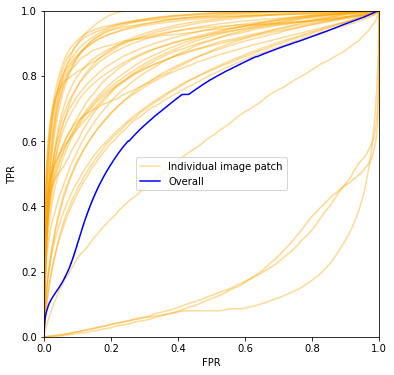

In [17]:
print(np.average(auc_scores))
print(np.std(auc_scores, ddof=1))
print(roc_auc_score(np.concatenate(nuclei_gts).reshape(-1), np.concatenate(OD_hs).reshape(-1)))

# Plot
plt.figure(figsize=(6, 6))
for i in range(len(he_indexes_test)):
    if i == 0:
        plt.plot(fprs[i], tprs[i], color='orange', alpha=0.4, label='Individual image patch')
    else:
        plt.plot(fprs[i], tprs[i], color='orange', alpha=0.4)
fpr, tpr, thresholds = roc_curve(np.concatenate(nuclei_gts).reshape(-1), np.concatenate(OD_hs).reshape(-1))
plt.plot(fpr, tpr, color='blue', label='Overall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

torch.save([fpr, tpr], "../outputs/2_roc_curve_evaluate_recon-waveletICA.pt")

# Session Info

In [15]:
!pip freeze

absl-py==0.7.0
altair==3.2.0
argh==0.26.2
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.2
backcall==0.1.0
base58==1.0.3
bleach==3.1.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
future==0.17.1
gast==0.2.2
grpcio==1.16.0
h5py==2.10.0
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinja2==2.10.1
jmespath==0.9.4
jsonschema==3.0.1
jupyter==1.0.0
jupyter-client==5.2.4
jupyter-console==6.0.0
jupyter-core==4.4.0
Keras==2.1.6
Keras-Applications==1.0.7
Keras-Preprocessing==1.0.9
kiwisolver==1.0.1
lifelines==0.21.3
lightgbm==2.3.1
Markdown==3.0.1
MarkupSafe==1.1.1
matplotlib==